# Dataset Creation

This notebook contains code used for generating handwriting images dataset using simple handwriting fonts available.<br>
Author: Shreyansh Tripathi<br>
email: [shreyanshtripathi03@gmail.com](Hidden_landing_URL)

The first version of this notebook is for creating a dummy dataset which can be extended easily to create bigger and advanced datasets using fonts from different languages.

# Extract words
English language has roughly 250000 words. The dataset generation requires words form a dictionary. Here, words are taken from words corpus provided by nltk. In this dummy dataset we are taking random 1000 words from the corpus and producing its images. 1000 words are taken and saved in a list.<br>
This can be extended to include most frequent words in a database in further implementations.

In [25]:
import random
import IAM_Metadata_Access_Functions as iam
import numpy
import scipy.stats as stats
from nltk.corpus import words

lines = iam.get_lines("/home/shreyansh/Downloads/xmlmetadataiam")
line_list = sorted(set(lines))    
line_vector = numpy.empty([len(line_list),1],dtype = object)
print(f'{len(line_vector)} different lines present')
for i in range(len(line_list)):
    line_vector[i][0] = line_list[i] 
print(line_vector)

1539 xml files accessed
13353 lines are present
12774 different lines present
[['"And that\'s the man whom you have been eating your']
 ['"But I want it!" she protested. "It\'s my ring."']
 ['"But something very untoward has']
 ...
 ['yourself,&quot; she said with mock severity.']
 ['yourselves. You can take it from']
 ['zone of optimum light intensity.']]


# Enter Fonts for Text Generation
Next step is to choose which fonts will be used for text generation. There are many fonts out which replicate human writing styles. In this implementation 29 fonts are used. All the fonts are taken from Google Fonts, [https://fonts.google.com](url_here).<br>

These are truetype fonts whose delegates are needed to be added to the library imagemagick used ahead in the implementation. Refer to any online resource or imagemagick's online forums for help.

In [26]:
fonts = ['Amatic SC_700.ttf','Amatic SC_regular.ttf','Beth Ellen_regular.ttf','Caveat Brush_regular.ttf','Cedarville Cursive_regular.ttf','Coming Soon_regular.ttf','Dawning of a New Day_regular.ttf','Gaegu_300.ttf','Gaegu_700.ttf','Gaegu_regular.ttf','Give You Glory_regular.ttf','Indie Flower_regular.ttf','Just Me Again Down Here_regular.ttf','League Script_regular.ttf','Merienda_700.ttf','Merienda One_regular.ttf','Merienda_regular.ttf','Nanum Brush Script_regular.ttf','Nanum Pen Script_regular.ttf','Nothing You Could Do_regular.ttf','Over the Rainbow_regular.ttf','Reenie Beanie_regular.ttf','Sacramento_regular.ttf','Stalemate_regular.ttf','Sue Ellen Francisco_regular.ttf','Swanky and Moo Moo_regular.ttf','The Girl Next Door_regular.ttf','Waiting for the Sunrise_regular.ttf','Zeyada_regular.ttf'] 
print(len(fonts))

29


# Storage Methods Used
The next task is to create single image generating functions which will further be used to create dataset of images.<br>
In this implementation dataset is stored using 3 methods:<br>
- Images in disk(.png format) and the metadata in csv
- Images and metadata both in lmdb objects with images as list of numpy array and metadata as lists of string and numbers
- Images and metadata in hdf5 format(used by Matlab as well). Images are stored as numpy array and metadata is stored as strings and numbers.

Each method has its own advantages and disadvantages. lmdb and hdf5 are used because the bulk-data can be accessed in less time. Although these methods take large storage space as compared to storing on disk making them harder to download, there are efficient compression methods which reduces the storage size considerably especially for hdf5 format making it easy to download and upload.<br>

The methods other than disk method has other advantages like consistency of data, data security as well. There are a lot of great resources to learn about these storage methods.

# Libraries Used
In this implementation various libraries are used but the major are the c-types binding of the imagemagick library for python named wand, PIL, pickle library to pickle and unpickle data lmdb and h5py for lmdb and hdf5 implementations. More can be read about installation and functionalities of these libraries on their official documentations.

# Creating single image storage functions
The image storage functions are implemented based on the algorithm gven in the paper: **Generating Synthetic Data for Text Recognition** by Praveen Krishnan and C.V. Jawahar.<br>
In brief the points mentioned in the paper are as follows:
-  The  vocabulary  of words needs tobe chosen from a dictionary.
- For each word chosen, a random font is sampled
- The image is rendered using the font rendered in the previous step.
- In this process, following  parameters are varied according to some distribution:  
 - kerning  level  (inter  character  space),
 - strokewidth,  from  a  defined  distribution.
 - The  pixel  distribution  of both foreground and background pixels are sampled from the corresponding  pixels  for  both  regions  from  a  Gaussian  distribution  where  the parameters such as mean and standard deviation are learned from the Fg and Bg region of IAM dataset.
 - Gaussian filtering is done to smooth the rendered image.

In [27]:
from wand.color import Color
from wand.image import Image
from wand.drawing import Drawing, FontMetrics



def datagen_diskfn(txt, fnt, fnt_sz, file_name, fmt = 'png'):
        #The lowerlimits, upperlimits, mean and variances are derived from the IAM dataset
        #as mentioned in the paper and are distributed through a gaussian distribution.
        lowerlimit, upperlimit = 190, 255
        mn, vari = 222.7, 8.45
        A = stats.truncnorm((lowerlimit - mn) / vari, (upperlimit - mn) / vari, loc=mn, scale=vari)
        d = A.rvs(1)
        d0 = str(d[0])
        
        lowerlimitf, upperlimitf = 10, 60
        mnf, varif = 33.34, 7.45
        B = stats.truncnorm((lowerlimitf - mnf) / varif, (upperlimitf - mnf) / varif, loc=mnf, scale=varif)
        c = B.rvs(1)
        c0 = str(c[0])
        
        with Color('rgb('+c0+','+c0+','+c0+')') as fg:
            with Color('rgb('+d0+','+d0+','+d0+')') as bg:
                with Image(width=1000, height=48, background = bg) as img:
                    img.format = 'gray'
                    img.type = 'grayscale'
                    img.colorspace = 'gray'
                    with Drawing() as draw:
                        draw.font = fnt
                        draw.font_size = fnt_sz
                        draw.fill_color = fg
                        lower, upper = -3.5, 5
                        mu, sigma = 0, 1.25
                        X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
                        a = X.rvs(1)
                        draw.text_kerning = a[0]
                        metrics = draw.get_font_metrics(img, txt)
                        with Image(width=int(metrics.text_width)+5, height=int(metrics.text_height), background = bg) as im:
                            img.format = 'gray'
                            img.type = 'grayscale'
                            img.colorspace = 'gray'
                            draw.text(5,0+int(metrics.ascender)+1, txt)
                            draw(im)
                            im.resize(1000,48)
                            lowergb, uppergb = 0, 1.2
                            mugb, sigmagb = 0.6, 0.2
                            GB = stats.truncnorm((lowergb - mugb) / sigmagb, (uppergb - mugb) / sigmagb, loc=mugb, scale=sigmagb)
                            gb = GB.rvs(1)
                            im.gaussian_blur(0, gb[0])
                            im.save(filename=file_name)

In [28]:
from wand.display import display
from wand.color import Color
from wand.image import Image
from wand.drawing import Drawing, FontMetrics
import io
import PIL

def datagen_lmdbfn(txt, fnt, fnt_sz):
    #The lowerlimits, upperlimits, mean and variances are derived from the IAM dataset
        #as mentioned in the paper and are distributed through a gaussian distribution.
        lowerlimit, upperlimit = 190, 255
        mn, vari = 222.7, 8.45
        A = stats.truncnorm((lowerlimit - mn) / vari, (upperlimit - mn) / vari, loc=mn, scale=vari)
        d = A.rvs(1)
        d0 = str(d[0])
        
        lowerlimitf, upperlimitf = 10, 60
        mnf, varif = 33.34, 7.45
        B = stats.truncnorm((lowerlimitf - mnf) / varif, (upperlimitf - mnf) / varif, loc=mnf, scale=varif)
        c = B.rvs(1)
        c0 = str(c[0])
        
        with Color('rgb('+c0+','+c0+','+c0+')') as fg:
            with Color('rgb('+d0+','+d0+','+d0+')') as bg:
                with Image(width=1000, height=48, background = bg) as img:
                    img.format = 'gray'
                    img.type = 'grayscale'
                    img.colorspace = 'gray'
                    with Drawing() as draw:	
                        draw.font = fnt
                        draw.font_size = fnt_sz
                        draw.fill_color = fg
                        lower, upper = -3.5, 5
                        mu, sigma = 0, 1.25
                        X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
                        a = X.rvs(1)
                        draw.text_kerning = a[0]
                        metrics = draw.get_font_metrics(img, txt)
                        with Image(width=int(metrics.text_width)+5, height=int(metrics.text_height), background = bg) as im:
                            im.format = 'gray'
                            im.type = 'grayscale'
                            im.colorspace = 'gray'
                            draw.text(5,0+int(metrics.ascender)+1, txt)
                            draw(im)
                            im.resize(1000,48)
                            lowergb, uppergb = 0, 1.2
                            mugb, sigmagb = 0.6, 0.2
                            GB = stats.truncnorm((lowergb - mugb) / sigmagb, (uppergb - mugb) / sigmagb, loc=mugb, scale=sigmagb)
                            gb = GB.rvs(1)
                            im.gaussian_blur(0, gb[0])
                            img_buffer = np.asarray(bytearray(im.make_blob(format='png')), dtype='uint8')
                            bytesio = io.BytesIO(img_buffer)
                            pil_img = PIL.Image.open(bytesio)
                            q = np.array(pil_img)
        return q

In [29]:
def datagen_hdf5fn(txt, fnt, fnt_sz):
        #The lowerlimits, upperlimits, mean and variances are derived from the IAM dataset
        #as mentioned in the paper and are distributed through a gaussian distribution.
        lowerlimit, upperlimit = 190, 255
        mn, vari = 222.7, 8.45
        A = stats.truncnorm((lowerlimit - mn) / vari, (upperlimit - mn) / vari, loc=mn, scale=vari)
        d = A.rvs(1)
        d0 = str(d[0])
        
        lowerlimitf, upperlimitf = 10, 60
        mnf, varif = 33.34, 7.45
        B = stats.truncnorm((lowerlimitf - mnf) / varif, (upperlimitf - mnf) / varif, loc=mnf, scale=varif)
        c = B.rvs(1)
        c0 = str(c[0])
        
        with Color('rgb('+c0+','+c0+','+c0+')') as fg:
            with Color('rgb('+d0+','+d0+','+d0+')') as bg:
                with Image(width=1000, height=48, background = bg) as img:
                    img.format = 'gray'
                    img.type = 'grayscale'
                    img.colorspace = 'gray'
                    with Drawing() as draw:	
                        draw.font = fnt
                        draw.font_size = fnt_sz
                        draw.fill_color = fg
                        lower, upper = -3.5, 5
                        mu, sigma = 0, 1.25
                        X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
                        a = X.rvs(1)
                        draw.text_kerning = a[0]
                        metrics = draw.get_font_metrics(img, txt)
                        with Image(width=int(metrics.text_width)+5, height=int(metrics.text_height), background = bg) as im:
                            im.format = 'gray'
                            im.type = 'grayscale'
                            im.colorspace = 'gray'
                            draw.text(5,0+int(metrics.ascender)+1, txt)
                            draw(im)
                            im.resize(1000,48)
                            lowergb, uppergb = 0, 1.2
                            mugb, sigmagb = 0.6, 0.2
                            GB = stats.truncnorm((lowergb - mugb) / sigmagb, (uppergb - mugb) / sigmagb, loc=mugb, scale=sigmagb)
                            gb = GB.rvs(1)
                            im.gaussian_blur(0, gb[0])
                            img_buffer = np.asarray(bytearray(im.make_blob(format='png')), dtype='uint8')
                            bytesio = io.BytesIO(img_buffer)
                            pil_img = PIL.Image.open(bytesio)
                            q = np.array(pil_img)
        return q

In [30]:
# import random
# from pathlib import Path
# from PIL import ImageDraw, ImageFont, Image
# from PIL import ImageFilter
# def datagen_diskfn(text, fnt, fnt_sz, file_name, fmt='PNG'):
#     # create a font object 
#     font = ImageFont.truetype(fnt,fnt_sz)
#     # determine dimensions of the text
#     dim = font.getsize(text)
#     print(dim)
#     # create a new image slightly larger that the text
#     im = Image.new('L', (dim[0]+2,dim[1]+2), 'grey')
#     d = ImageDraw.Draw(im)
#     x, y = im.size
#     r = random.randint
#     # add the text to the image
#     d.text((0,-5.0), text,255, font=font)
#     # save the image to a file
#     im = im.resize((128,48))
#     im.save(file_name, format = fmt)

In [31]:
# import random
# from pathlib import Path
# from PIL import ImageDraw, ImageFont, Image
# from PIL import ImageFilter
# def datagen_lmdbfn(text, fnt, fnt_sz):
#     # create a font object 
#     font = ImageFont.truetype(fnt,fnt_sz)
#     # determine dimensions of the text
#     dim = font.getsize(text)
#     # create a new image slightly larger that the text
#     im = Image.new('L', (dim[0]+2,dim[1]+2), 'grey')
#     d = ImageDraw.Draw(im)
#     x, y = im.size
#     r = random.randint
#     # add the text to the image
#     d.text((0,-5), text,255, font=font)
#     # save the image to a file
#     #im.save(file_name, format=fmt)
#     im = im.resize((128,48))
#     im = np.array(im)
#     return im


In [32]:
# import random
# from pathlib import Path
# from PIL import ImageDraw, ImageFont, Image
# from PIL import ImageFilter
# def datagen_hdf5fn(text, fnt, fnt_sz):
#     # create a font object 
#     font = ImageFont.truetype(fnt,fnt_sz)
#     # determine dimensions of the text
#     dim = font.getsize(text)
#     # create a new image slightly larger that the text
#     im = Image.new('L', (dim[0]+2,dim[1]+2), 'grey')
#     d = ImageDraw.Draw(im)
#     x, y = im.size
#     r = random.randint
#     # add the text to the image
#     d.text((0,-5), text,255, font=font)
#     # save the image to a file
#     #im.save(file_name, format=fmt)
#     im = im.resize((128,48))
#     im = np.array(im)
#     return im


# Create Object Definitions for lmdb objects
To create lmdb image objects, a class is made which involves function for creating objects and a function for getting images back from the database. This class is necessary to be shipped with the data in order to reconstuct original images from the lmdb objects.<br>
The object has following fields:<br>
- channels - channels in the image
- shape - dimensions of the image(in pixels)
- image - byteform of the actual image
- ALLlabel - label representing class id of each image and refers to list index in the ALLtext field
- ALLtext - contains actual words
- SET - contains 0 if image is in the validation set and 1 if image is in the training set.

In [33]:
class ImageObject:
    def __init__(self, image, label, text, trnORval):
        # Dimensions of image for reconstruction - not really necessary 
        # for this dataset, but some datasets may include images of 
        # varying sizes
        self.channels = 1
        self.shape = image.shape[:2]
        self.image = image.tobytes()
        self.ALLlabel = label
        self.ALLtext = text
        self.SET = trnORval
        
    def get_image(self):
        """ Returns the image as a numpy array. """
        image = np.frombuffer(self.image, dtype=np.uint8)
        return image.reshape(*self.shape, self.channels)

# Storage functions for the different methods
## Disk Storage
Contains images with following properties:
- all images are stored in png format.
- all images are scaled to (128X48) pixels size.
- images are grayscale.

Contains 5 files for metadata:<br>
ALLlabel: label representing class id of each image and refers to list index in the ALLtext field<br>
ALLtext: contains actual words<br>
ALLnames: relative path of each image.<br>
TRNInd: Values denoting image numbers which will be used for training<br>
VALInd: Values denoting image numbers which will be used for validation<br>

## lmdb Storage

Contains images with following properties:
- all images are stored in list of numpy array format.
- all images are scaled to (128X48) pixels size.
- images are grayscale.

Contains 4 field in ImageObject for metadata:<br>
multiimages: list of numpy array images to be stored.<br>
ALLlabel: label representing class id of each image and refers to list index in the ALLtext field<br>
ALLtext: contains actual words<br>
TRNorVal: 0 or 1 denoting validation and training set respectively<br>

## hdf5 Storage
Contains images with following properties:
- all images are stored in png format.
- all images are scaled to (128X48) pixels size.
- images are grayscale.

Contains 5 files for metadata:<br>
imageset: dataset of numpy array images to be stored h5py.h5t.NATIVE_UINT8 format<br>
labelset: dataset of label representing class id of each image and refers to list index in the ALLtext field h5py.h5t.NATIVE_INT16 format<br>
textset: dataset of contains actual words string format<br>
trnset: dataset of Values denoting image numbers which will be used for training h5py.h5t.NATIVE_INT16 format<br>
valset: dataset of Values denoting image numbers which will be used for validation h5py.h5t.NATIVE_INT16 format<br>



In [34]:
import csv
import pickle
import numpy as np
import lmdb
import h5py
import math
def store_disk(num_images, num_fonts):
    total_images = num_images*num_fonts
    mylist = list(range(total_images))
    random.shuffle(mylist)
    val = mylist[:int(total_images/4)]
    trn = mylist[int(total_images/4):]
    val.sort()
    trn.sort()
    y_vector = numpy.empty([total_images,1],dtype = object)
    y_list,name_list = [],[]
    name_vector = numpy.empty([total_images,1],dtype = object)
    
   

    for y in range(num_images):
        new_dir = Path("datagen_disk/"+str(y+1))
        new_dir.mkdir(parents=True, exist_ok=True)
        sample = random.sample(fonts,k=num_fonts)
        for x in range (num_fonts):
            datagen_diskfn(line_list[y], '/home/shreyansh/.fonts/typecatcher/'+str(sample[x]), 30, str(new_dir)+'/'+str(x)+'.png')
            y_list.append(y)
            path = str(new_dir)+'/'+str(x)+'.png'
            name_list.append(path)
            
               
    for i in range(total_images):
        y_vector[i][0] = y_list[i]
    
    for i in range(total_images):
        name_vector[i][0] = name_list[i]
        
    with open("datagen_disk/ALLtext.csv", "w") as csvfile:
        writer = csv.writer(csvfile, delimiter=",", quotechar="|", quoting=csv.QUOTE_MINIMAL)
        writer.writerows(line_vector)
    with open("datagen_disk/ALLlabels.csv", "w") as csvfile:
        writer = csv.writer(csvfile, delimiter=",", quotechar="|", quoting=csv.QUOTE_MINIMAL)
        writer.writerows(y_vector)
    with open("datagen_disk/ALLnames.csv", "w") as csvfile:
        writer = csv.writer(csvfile, delimiter=",", quotechar="|", quoting=csv.QUOTE_MINIMAL)
        writer.writerows(name_vector)
    with open("datagen_disk/VALInd.csv", "w") as csvfile:
        writer = csv.writer(csvfile, delimiter=",", quotechar="|", quoting=csv.QUOTE_MINIMAL)
        writer.writerows(map(lambda x: [x], val))
    with open("datagen_disk/TRNInd.csv", "w") as csvfile:
        writer = csv.writer(csvfile, delimiter=",", quotechar="|", quoting=csv.QUOTE_MINIMAL)
        writer.writerows(map(lambda x: [x], trn))         
                


def store_lmdb(num_images, num_fonts):
    total_images = num_images*num_fonts
    mylist = list(range(total_images))
    random.shuffle(mylist)
    val = mylist[:int(total_images/4)]
    
    iterations = 0
    map_size = total_images * 6144 * 10
    multiimages,texts,labels,trnORval = [],[],[],[]
    
    for y in range(num_images):
        sample = random.sample(fonts,k=num_fonts)
        texts.append(line_list[y])
        for x in range (num_fonts):
            iterations += iterations
            multiimages.append(datagen_lmdbfn(line_list[y], '/home/shreyansh/.fonts/typecatcher/'+str(sample[x]), 30))
            labels.append(y)
            if iterations in val:
                trnORval.append(0)
            else:
                trnORval.append(1)
            
    

    lmdb_dir = Path("datagen_lmdb")
    lmdb_dir.mkdir(parents=True, exist_ok=True)
    
    # Create a new LMDB DB for all the images
    env = lmdb.open(str(lmdb_dir / f"{total_images}_lmdb"), map_size=map_size)

    # Same as before — but let's write all the images in a single transaction
    with env.begin(write=True) as txn:
        j = -0.1
        for i in range(total_images):
            j = j + 0.1
            k = math.floor(j)
            # All key-value pairs need to be Strings
            value = ImageObject(multiimages[i], labels[i],texts[k],trnORval[i])
            key = f"{i:08}"
            txn.put(key.encode("ascii"), pickle.dumps(value))
    env.close()

def store_hdf5(num_images, num_fonts):
    total_images = num_images*num_fonts
    hdf5_dir = Path("datagen_hdf5")
    hdf5_dir.mkdir(parents=True, exist_ok=True)

    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{total_images}_many.h5", "w")
    
    mylist = list(range(total_images))
    random.shuffle(mylist)
    listm = mylist[:int(total_images/4)]
    
    iterations = -1
    multiimages,labels,trn, texts,val = [],[],[],[],[]
    for y in range(num_images):
        sample = random.sample(fonts,k=num_fonts)
        texts.append(line_list[y])
        
        for x in range (num_fonts):
            iterations +=1
            multiimages.append(datagen_hdf5fn(line_list[y], '/home/shreyansh/.fonts/typecatcher/'+str(sample[x]), 30))
            labels.append(y)
            if iterations in listm:
                val.append(iterations)
            else:
                trn.append(iterations)
                
            
    asciiList = [n.encode("ascii", "ignore") for n in texts]
    
    # Create a dataset in the file
    dataset = file.create_dataset(
        "images", np.shape(multiimages), h5py.h5t.NATIVE_UINT8, data=multiimages
    )
    labelset = file.create_dataset(
        "ALLlabels", np.shape(labels), h5py.h5t.NATIVE_INT16, data=labels
    )
    textset = file.create_dataset(
        "ALLtext", (len(asciiList),1), 'S100', data=asciiList
    )
    valset = file.create_dataset(
        "VALInd", np.shape(val), h5py.h5t.NATIVE_INT16, data=val
    )
    trainset = file.create_dataset(
        "TRNInd", np.shape(trn), h5py.h5t.NATIVE_INT16, data=trn
    )
    


In [35]:
from pathlib import Path
num_images = len(line_list)
num_fonts = 1
_store_many_funcs = dict(
    disk=store_disk, lmdb=store_lmdb, hdf5=store_hdf5)

from timeit import timeit

store_many_timings = {"disk": [], "lmdb": [], "hdf5": []}

for method in ("lmdb", "hdf5", "disk"):
    t = timeit(
        "_store_many_funcs[method](num_images,num_fonts)",
        setup="",
        number=1,
        globals=globals(),
    )
    store_many_timings[method].append(t)

    # Print out the method, cutoff, and elapsed time
    print(f"Method: {method}, Time usage: {t}")

Method: lmdb, Time usage: 538.071832769001
Method: hdf5, Time usage: 550.0459772969989
Method: disk, Time usage: 515.0402498629992


<class 'scipy.stats._distn_infrastructure.rv_frozen'>
[ 1.62413049  0.87839933  1.32226301 -0.86860496 -0.54126131  0.08599879
  1.59537972  1.19224392  1.89666146 -0.0922219 ]


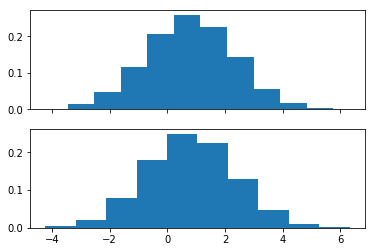

In [36]:
import matplotlib.pyplot as plt
import scipy.stats as stats

lower, upper = -3.5, 6
mu, sigma = 0.8, 1.5
X = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
N = stats.norm(loc=mu, scale=sigma)
print(type(X))
print(X.rvs(10))
fig, ax = plt.subplots(2, sharex=True)
ax[0].hist(X.rvs(10000), normed=True)
ax[1].hist(N.rvs(10000), normed=True)
plt.show()